# Lab 6: Convolutional Neural Networks

### Katherine Wirskye, Lucas Li, Ethan Li, and Kaylie Nguyen (5000-level students)

Link to dataset: **insert this shi**

## Preparation

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # so that I don't use GPU
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # Disable all GPUs

import numpy as np
import matplotlib.pylab as plt

#import pandas as pd
# from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Model
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.regularizers import l2

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
# locate directories
folder = "allimages"

image_directories = [
    os.path.join(folder, "angry"),
    os.path.join(folder, "disgust"),
    os.path.join(folder, "fear"),
    os.path.join(folder, "happy"),
    os.path.join(folder, "neutral"),
    os.path.join(folder, "sad"),
    os.path.join(folder, "surprise")
]

# function to get image paths and the emotion label
def get_image_paths_and_labels(image_directories):
    image_paths = [] #stores image paths
    labels = [] #stores labels

    # goes through each of the 7 directories 
    for i, directory in enumerate(image_directories):
        emotion_label = os.path.basename(directory) # captures the emotion label
        # goes through each image in each directory
        for filename in os.listdir(directory):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_paths.append(os.path.join(directory, filename)) #appends image path to list
                labels.append(emotion_label) # appends emotion label to list

    return image_paths, labels

# gets image path and label for training and testing set
image_paths, image_labels = get_image_paths_and_labels(image_directories)

print("Number of images:", len(image_paths))
print("Number of labels:", len(image_labels))

FileNotFoundError: [Errno 2] No such file or directory: 'allimages/angry'

In [ ]:
from collections import Counter

# Count the occurrences of each emotion label
label_counts = Counter(image_labels)

# Print the number of images for each emotion
print("Number of images in each emotion category:")
for emotion, count in label_counts.items():
    print(f"{emotion}: {count}")


In [3]:
def load_and_preprocess_images(image_paths, img_width, img_height):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_array /= 255.0 # added this normalization
        images.append(img_array)
    return np.array(images)

img_width = 48
img_height = 48

X = load_and_preprocess_images(image_paths, img_width, img_height)

label_encoder = LabelEncoder()

# Fit and transform the labels for training data
labels_encoded = label_encoder.fit_transform(image_labels)

# Convert the encoded labels to one-hot encoded vectors
y = to_categorical(labels_encoded)

print(len(X), len(y))

35685 35685


### Performance Metric

Although we initially thought about using accuracy as our evaluation metric, we decided it would not be representative of our models' performance because our dataset is imbalanced. An example of this is how there are less than 600 images classified as disgust whereas the happiness category has over 8000 images. In an unbalanced dataset, some emotions might overshadow or dominate others especially if they occur more often, so a model can achieve higher accuracy by predicting the dominant label. This means that accuracy is a misleading evaluation of the model's performance. 
To address this, we are using the F1 score, which combines precision and recall into one metric. In this business case, precision is the proportion of images predicted to belong to a specific emotion that are actually labeled correctly with that emotion, while recall is the   proportion of actual instances of a given emotion that are correctly identified by the model. The F1 score uses precision and recall to make a better assessment of the model's ability to make correct predictions while avoiding false positives and false negatives. The F1 score is superior to accuracy for this task because it evaluates the model’s performance for all classes, even the underrepresented ones, which promotes a more holistic view of its effectiveness. Unlike accuracy, which treats all predictions equally, the F1 score is particularly sensitive to the trade-off between false positives and false negatives, ensuring the model is not biased toward dominant classes.

In [ ]:
def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Round predictions to 0 or 1
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)

### Data Splitting Method

We are implementing the 5 fold stratified cross validation method for our emotion classification model to ensure that the training and validation sets are representative of the entire dataset. Stratified cross-validation maintains the proportion of each class in both the training and validation sets, which is especially important for imbalanced dataset. In our case, the dataset contains images of seven primary emotions, and stratification helps to prevent scenarios where one fold might have an overrepresentation or underrepresentation of certain emotions, especially considering that certain emotion categories have more images than others. This ensures that each fold provides a reliable evaluation of the model's ability to generalize across all classes, resulting in more consistent and unbiased performance metrics.
Stratified 5-fold cross-validation is particularly appropriate for our convolutional neural network because it allows us to make the best use of our data while ensuring that the model does not overfit to any one portion of the dataset. Each fold gives the model a unique training set while still using all the data for validation at some point. This helps the model learn generalizable features and better reflects how the model will perform on our testing data. The use of cross-validation also reduces the risk of overfitting, as the model's performance is evaluated multiple times on different data splits, providing a more accurate estimate of its true performance.

In [4]:
# define the 5-fold stratified cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# we can probably changes this to 10 later (10 is probably better for statistical test)

## Modeling

### Data Expansion

I think we're just gonna add the layers actually in the models. I've added some layers for the first one. So we can just talk about the data expansion here :D

So far, we have:
- random horizontal flip
- random rotation
- random translation
- random zoom

*Setup the training to use data expansion in Keras (also called data augmentation). 
Explain why the chosen data expansion techniques are appropriate for your dataset. 
You should make use of Keras augmentation layers, like in the class examples.*


The chosen data augmentation techniques—random horizontal flip, random rotation, random translation, and random zoom—are appropriate for our emotion image dataset because they introduce variability in the images without altering their core features. Emotion recognition may rely on small differences such as facial expressions and body language, and small changes in the orientation or position of the face in an image can occur in the real-world. Random horizontal flip simulates different perspectives of the person, helping the model become less sensitive to the direction in which the person's face is facing. Random rotation enables the model to learn to recognize emotions even when the face is rotated, accounting for variations in head tilt or camera angles. This is really important in the real-world where the orientation of a person will certainly vary.
Similarly, random translation and random zoom add further diversity by shifting the face within the frame and altering its scale. These transformations mimic real-world variations, such as the person's movement or different focal lengths of cameras. Random translation helps the model recognize emotions even when the person's position shifts within the image, while random zoom simulates the effect of varying distances between the camera and the face. These augmentations help prevent the model from overfitting to specific image features, making it more generalizable when encountering new, unseen data in emotion recognition tasks. These augmentations make it so that our model can better handle minute differences in facial expressions within images. 


### Model 1

*just for my reference, we can condense this later lol (from ChatGPT obv*)

This Convolutional Neural Network (CNN) is designed for multi-class image classification, specifically targeting 7 distinct categories. The architecture begins with data augmentation layers to improve generalization and robustness. These augmentations, including random horizontal flips, rotations (±10%), translations, and zooms, simulate real-world variations in the input data, helping the model learn to handle diverse scenarios. The augmented data is then processed through a sequence of convolutional layers that progressively extract hierarchical features. The initial convolutional layers use 64 filters with 3×3 kernels to capture low-level features such as edges, followed by max-pooling to downsample and batch normalization to stabilize training. As the layers progress, the filter count increases to 128 and then 256, enabling the model to recognize more complex patterns and abstract features, while additional max-pooling reduces spatial dimensions to make the data manageable for the fully connected layers.

Once the convolutional layers have extracted meaningful features, the model transitions to the dense layers for decision-making. The flattening layer converts the 2D feature maps into a 1D vector, which is then passed through a series of dense layers with 1024, 512, and 128 neurons. Each dense layer refines the feature representations, with ReLU activations introducing non-linearity. Dropout layers are incorporated between the dense layers, with 50% and 25% dropout rates, to reduce overfitting by preventing the model from relying too heavily on specific neurons. The final output layer has 7 neurons with a softmax activation function, generating probabilities for each class, ensuring the outputs sum to 1.

To optimize training, the model uses the Adam optimizer, which adapts the learning rate dynamically, and the categorical cross-entropy loss function, ideal for multi-class classification tasks. Accuracy is tracked as the primary metric during training and evaluation. Regularization techniques like batch normalization and dropout, combined with the augmentation strategies, mitigate overfitting and enhance the model’s ability to generalize to unseen data. This comprehensive architecture enables the CNN to effectively extract, abstract, and classify features, aiming to achieve high accuracy in both training and deployment.

In [29]:
# for tracking performance
training_results_model1_1 = []
testing_results_model1_1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    # Kaylie's code yay!
    # build a model
    input_shape = (img_width, img_height, 3)

    model1_1 = Sequential([

        # data expansion and augmentation (should be talked abt previously)
        # these might be decreasing accuracy (I don't know if they're contradicting the pre processing Kaylie did)
        # need to discuss this ^^
        RandomFlip("horizontal"),
        RandomRotation(0.10),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.1, width_factor=0.1),

        # Kaylie's model
        Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(7, activation='softmax')
    ])

    epochs = 20
    batch_size = 64

    model1_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # traing the model
    history = model1_1.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    # add verbose = 0 later!!

    # track accuracy and loss for training data and validation data
    training_results_model1_1.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })

    # evaluate the model on the test data
    test_loss, test_accuracy = model1_1.evaluate(X_test, y_test)
    # add verbose = 0 later!!

    # remove the print statements later
    # we won't want them when we run 10 times
    print('Test Loss: ', test_loss)
    print("Test Accuracy:", test_accuracy)

    testing_results_model1_1.append(test_accuracy)

    # breaking for now so that we don't waste time running it a billion times (actually only five times LOLLLLL)
    break

Epoch 1/20
308/357 [========================>.....] - ETA: 7s - loss: 1.7987 - accuracy: 0.2563

In [ ]:
# !!!THIS MAY NEED TO BE MODIFIED TO MAKE IT WORK. I DIDN'T WANNA COMPLETELY MESS UP YOUR CODE AND DELETE SO I ADDED IT HERE. 


training_results_model1_1.append({
        'loss': history.history['loss'],
        'f1_score': history.history['f1_score_metric'],
        'val_loss': history.history['val_loss'],
        'val_f1_score': history.history['val_f1_score_metric']
    })

    # Evaluate the model on the test data
    y_test_pred = model1_1.predict(X_test)
    y_test_pred_labels = tf.argmax(y_test_pred, axis=1)
    y_test_true_labels = tf.argmax(y_test, axis=1)

    # Calculate the F1 score for the test set
    test_f1 = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')
    print("Test F1 Score:", test_f1)

    testing_results_model1_1.append(test_f1)

   
    

##### Loss Across Training Iterations

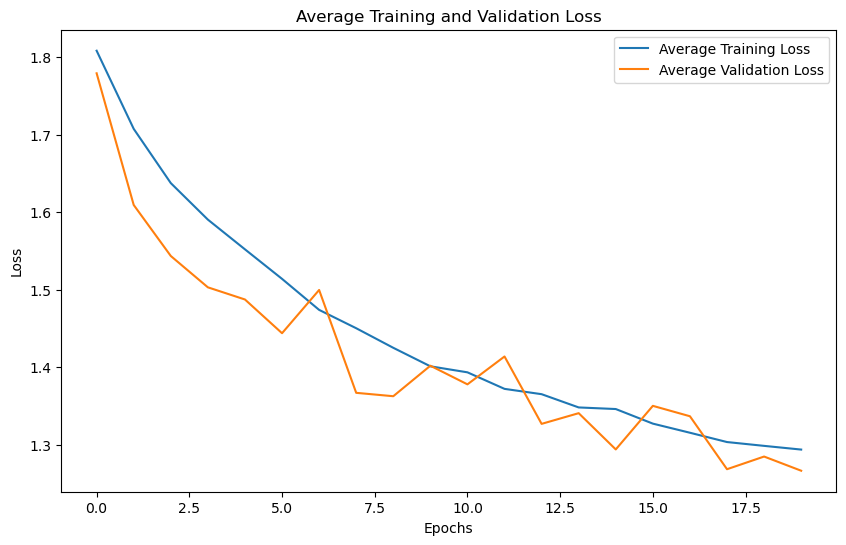

In [ ]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model1_1[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss1_1 = []
avg_val_loss1_1 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model1_1]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model1_1]
    
    avg_loss1_1.append(np.mean(epoch_loss))
    avg_val_loss1_1.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss1_1, label='Average Training Loss')
plt.plot(avg_val_loss1_1, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

##### Performance Across Training Iterations

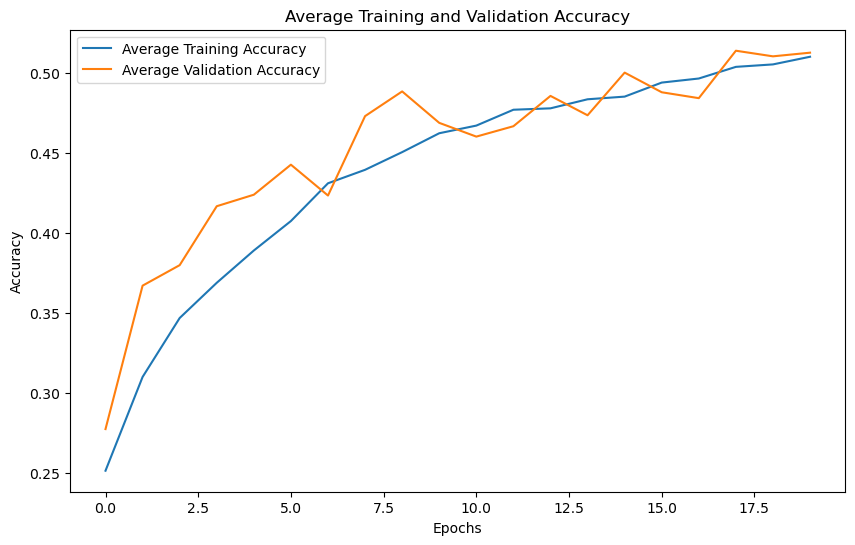

In [ ]:
# Initialize lists to store the average accuracy and validation accuracy across all instances
avg_accuracy1_1 = []
avg_val_accuracy1_1 = []

# Calculate the average accuracy and validation accuracy for each epoch
for epoch in range(num_epochs):
    epoch_accuracy = [result['accuracy'][epoch] for result in training_results_model1_1]
    epoch_val_accuracy = [result['val_accuracy'][epoch] for result in training_results_model1_1]
    
    avg_accuracy1_1.append(np.mean(epoch_accuracy))
    avg_val_accuracy1_1.append(np.mean(epoch_val_accuracy))

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_accuracy1_1, label='Average Training Accuracy')
plt.plot(avg_val_accuracy1_1, label='Average Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# !!! F1 SCORE INSTEAD OF ACCURACY


# Initialize lists to store the average F1 score and validation F1 score across all instances
avg_f1_score1_1 = []
avg_val_f1_score1_1 = []

# Calculate the average F1 score and validation F1 score for each epoch
for epoch in range(num_epochs):
    epoch_f1_score = [result['f1_score'][epoch] for result in training_results_model1_1]
    epoch_val_f1_score = [result['val_f1_score'] [epoch] for result in training_results_model1_1]
    
    avg_f1_score1_1.append(np.mean(epoch_f1_score))
    avg_val_f1_score1_1.append(np.mean(epoch_val_f1_score))

# Plot the average F1 score for training and validation across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_f1_score1_1, label='Average Training F1 Score')
plt.plot(avg_val_f1_score1_1, label='Average Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Average Training and Validation F1 Score')
plt.legend()
plt.show()

##### Testing Performance

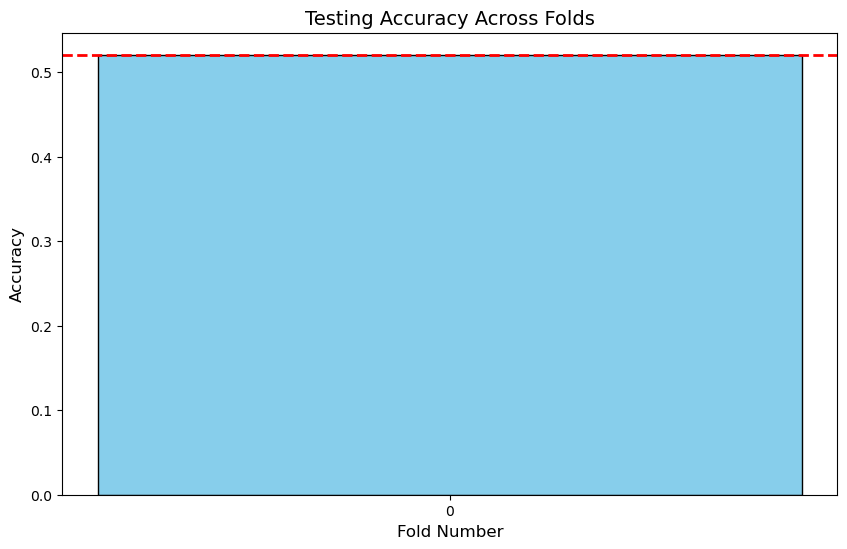

Average Accuracy:  0.5208070874214172
Standard Deviation:  0.0


In [ ]:
# Calculate the average tseting accuracy
average1_1 = np.mean(testing_results_model1_1)
std1_1 = np.std(testing_results_model1_1)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model1_1)), testing_results_model1_1, color='skyblue', edgecolor='black', label='Values')

# Plot the average as a horizontal line
plt.axhline(average1_1, color='red', linestyle='--', linewidth=2, label=f'Average ({average1_1:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Testing Accuracy Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model1_1)))

# Show the plot
plt.show()

# Print average and standard deviation for accuracy
print("Average Accuracy: ", average1_1)
print("Standard Deviation: " , std1_1)

In [ ]:
# !!! IM REALLY HOPING THIS WORKS OMG

# Calculate the average testing F1 score and standard deviation
average_f1_score1_1 = np.mean(testing_results_model1_1)
std_f1_score1_1 = np.std(testing_results_model1_1)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model1_1)), testing_results_model1_1, color='skyblue', edgecolor='black', label='F1 Scores')

# Plot the average as a horizontal line
plt.axhline(average_f1_score1_1, color='red', linestyle='--', linewidth=2, label=f'Average F1 Score ({average_f1_score1_1:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Testing F1 Score Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model1_1)))

# Show the plot
plt.legend()
plt.show()

# Print average and standard deviation for F1 score
print("Average F1 Score: ", average_f1_score1_1)
print("Standard Deviation: ", std_f1_score1_1)


#### Model 1 with Changed Parameters

In [ ]:
# for tracking performance
training_results_model1_2 = []
testing_results_model1_2 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    # Kaylie's code yay!
    # build a model
    input_shape = (img_width, img_height, 3)

    model1_2 = Sequential([

        # data expansion and augmentation (should be talked abt previously)
        # these might be decreasing accuracy (I don't know if they're contradicting the pre processing Kaylie did)
        # need to discuss this ^^
        RandomFlip("horizontal"),
        RandomRotation(0.10),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.1, width_factor=0.1),

        # Kaylie's model
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(7, activation='softmax')
    ])

    epochs = 20
    batch_size = 64

    model1_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # traing the model
    history = model1_2.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    # add verbose = 0 later!!

    # track accuracy and loss for training data and validation data
    training_results_model1_2.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })

    # evaluate the model on the test data
    test_loss, test_accuracy = model1_2.evaluate(X_test, y_test)
    # add verbose = 0 later!!

    # remove the print statements later
    # we won't want them when we run 10 times
    print('Test Loss: ', test_loss)
    print("Test Accuracy:", test_accuracy)

    testing_results_model1_2.append(test_accuracy)

    # breaking for now so that we don't waste time running it a billion times (actually only five times LOLLLLL)
    break

Epoch 1/20
 54/357 [===>..........................] - ETA: 3:12 - loss: 1.9054 - accuracy: 0.2199

KeyboardInterrupt: 

In [ ]:
# !!! CHANGE TO F1 SCORE

training_results_model1_2.append({
        'loss': history.history['loss'],
        'f1_score': history.history['f1_score_metric'],
        'val_loss': history.history['val_loss'],
        'val_f1_score': history.history['val_f1_score_metric']
    })

    # Evaluate the model on the test data
    y_test_pred = model1_2.predict(X_test)
    y_test_pred_labels = tf.argmax(y_test_pred, axis=1)
    y_test_true_labels = tf.argmax(y_test, axis=1)

    # Calculate the F1 score for the test set
    test_f2 = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')
    print("Test F1 Score:", test_f1)

    testing_results_model1_1.append(test_f2)

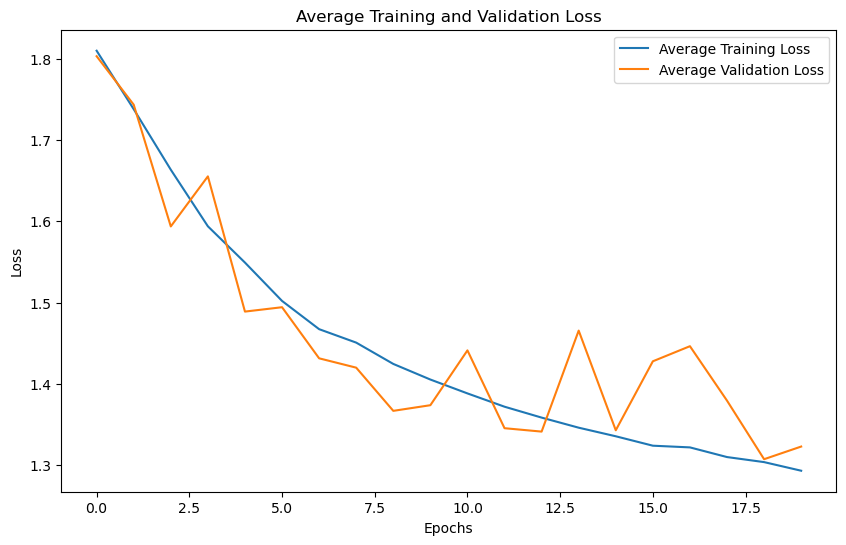

In [ ]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model1_2[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss1_2 = []
avg_val_loss1_2 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model1_2]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model1_2]
    
    avg_loss1_2.append(np.mean(epoch_loss))
    avg_val_loss1_2.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss1_2, label='Average Training Loss')
plt.plot(avg_val_loss1_2, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

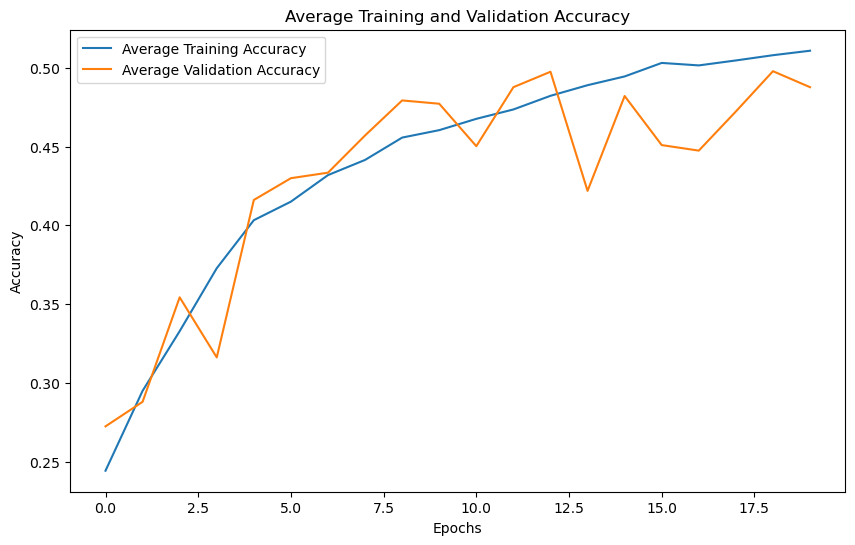

In [ ]:
# Initialize lists to store the average accuracy and validation accuracy across all instances
avg_accuracy1_2 = []
avg_val_accuracy1_2 = []

# Calculate the average accuracy and validation accuracy for each epoch
for epoch in range(num_epochs):
    epoch_accuracy = [result['accuracy'][epoch] for result in training_results_model1_2]
    epoch_val_accuracy = [result['val_accuracy'][epoch] for result in training_results_model1_2]
    
    avg_accuracy1_2.append(np.mean(epoch_accuracy))
    avg_val_accuracy1_2.append(np.mean(epoch_val_accuracy))

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_accuracy1_2, label='Average Training Accuracy')
plt.plot(avg_val_accuracy1_2, label='Average Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# !!! IM REALLY HOPING THIS WORKS OMG

# Calculate the average testing F1 score and standard deviation
average_f1_score1_2 = np.mean(testing_results_model1_2)
std_f1_score1_2 = np.std(testing_results_model1_2)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model1_2)), testing_results_model1_2, color='skyblue', edgecolor='black', label='F1 Scores')

# Plot the average as a horizontal line
plt.axhline(average_f1_score1_2, color='red', linestyle='--', linewidth=2, label=f'Average F1 Score ({average_f1_score1_2:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Testing F1 Score Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model1_2)))

# Show the plot
plt.legend()
plt.show()

# Print average and standard deviation for F1 score
print("Average F1 Score: ", average_f1_score1_2)
print("Standard Deviation: ", std_f1_score1_2)

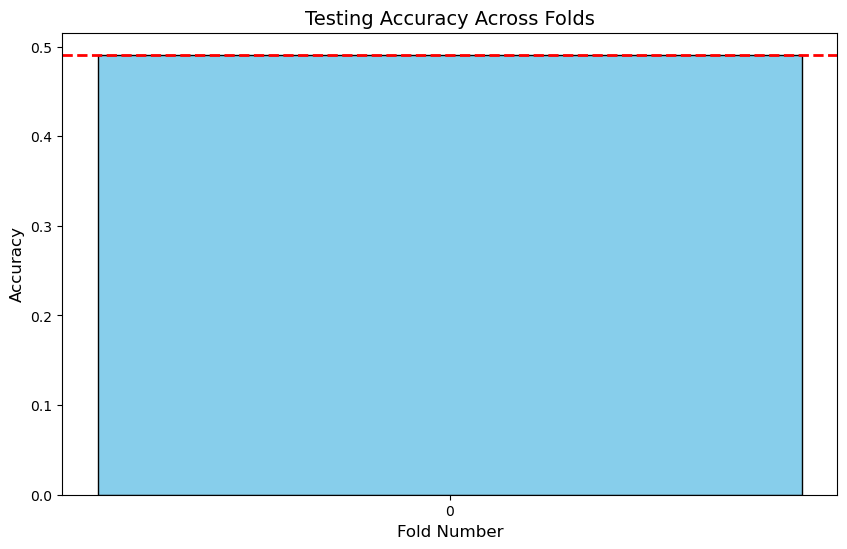

Average Accuracy:  0.49096259474754333
Standard Deviation:  0.0


In [ ]:
# Calculate the average tseting accuracy
average1_2 = np.mean(testing_results_model1_2)
std1_2 = np.std(testing_results_model1_2)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model1_2)), testing_results_model1_2, color='skyblue', edgecolor='black', label='Values')

# Plot the average as a horizontal line
plt.axhline(average1_2, color='red', linestyle='--', linewidth=2, label=f'Average ({average1_1:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Testing Accuracy Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model1_2)))

# Show the plot
plt.show()

# Print average and standard deviation for accuracy
print("Average Accuracy: ", average1_2)
print("Standard Deviation: " , std1_2)

In [ ]:
# !!! it's the above code but for f1

# Calculate the average testing F1 score and standard deviation
average_f1_score1_2 = np.mean(testing_results_model1_2)
std_f1_score1_2 = np.std(testing_results_model1_2)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model1_2)), testing_results_model1_2, color='skyblue', edgecolor='black', label='F1 Scores')

# Plot the average as a horizontal line
plt.axhline(average_f1_score1_2, color='red', linestyle='--', linewidth=2, label=f'Average F1 Score ({average_f1_score1_2:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Testing F1 Score Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model1_2)))

# Show the plot
plt.legend()
plt.show()

# Print average and standard deviation for F1 score
print("Average F1 Score: ", average_f1_score1_2)
print("Standard Deviation: ", std_f1_score1_2)


### Model 2 (Trying Larson's with the same parameters)

In [9]:
# for tracking performance
training_results_model2_1 = []
testing_results_model2_1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    ### REPLACE THIS    
    # changes: 
    #    1. Baseline: 2 conv layers and two output layers
    cnn1 = Sequential()

    # data augmentation 
    cnn1.add(RandomFlip("horizontal"))
    cnn1.add(RandomRotation(0.10))
    cnn1.add(RandomTranslation(height_factor=0.1, width_factor=0.1))
    cnn1.add(RandomZoom(height_factor=0.1, width_factor=0.1))

    num_filt_layers = [24, 24]
    for num_filters in num_filt_layers:
        cnn1.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        padding='same') )
        cnn1.add( Activation('relu'))
        cnn1.add( MaxPooling2D(pool_size=(2, 2), 
                            ) )
        

    # add one layer on flattened output
    cnn1.add( Flatten() )
    cnn1.add( Dense(1024, activation='relu') )
    cnn1.add( Dense(512, activation='relu') )
    cnn1.add( Dense(128, activation='relu') )
    cnn1.add( Dense(7, activation='softmax') )

    # Let's train the model 
    cnn1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    input_shape = [None, 48,48,3]
    cnn1.build(input_shape)

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    history = cnn1.fit(X_train_split, y_train_split, 
            batch_size=64, epochs=20, 
            shuffle=True, verbose=1,
            validation_data=(X_val,y_val))

    # track accuracy and loss for training data and validation data
    training_results_model2_1.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })

    # evaluate the model on the test data
    test_loss, test_accuracy = cnn1.evaluate(X_test, y_test)
    # add verbose = 0 later!!

    # remove the print statements later
    # we won't want them when we run 10 times
    print('Test Loss: ', test_loss)
    print("Test Accuracy:", test_accuracy)

    testing_results_model2_1.append(test_accuracy)

    # breaking for now so that we don't waste time running it a billion times (actually only five times LOLLLLL)
    break

Epoch 1/20
357/357 [==============================] - 35s 96ms/step - loss: 1.7996 - accuracy: 0.2547 - val_loss: 1.7523 - val_accuracy: 0.2818
Epoch 2/20
357/357 [==============================] - 46s 128ms/step - loss: 1.7479 - accuracy: 0.2792 - val_loss: 1.7051 - val_accuracy: 0.3039
Epoch 3/20
357/357 [==============================] - 38s 107ms/step - loss: 1.7202 - accuracy: 0.3016 - val_loss: 1.7306 - val_accuracy: 0.3061
Epoch 4/20
357/357 [==============================] - 31s 87ms/step - loss: 1.6878 - accuracy: 0.3237 - val_loss: 1.6054 - val_accuracy: 0.3688
Epoch 5/20
357/357 [==============================] - 28s 80ms/step - loss: 1.6487 - accuracy: 0.3486 - val_loss: 1.5623 - val_accuracy: 0.3989
Epoch 6/20
357/357 [==============================] - 31s 88ms/step - loss: 1.6235 - accuracy: 0.3579 - val_loss: 1.5114 - val_accuracy: 0.4149
Epoch 7/20
357/357 [==============================] - 37s 105ms/step - loss: 1.5957 - accuracy: 0.3717 - val_loss: 1.5038 - val_accura

In [ ]:
# !!! f1 score


# Track accuracy and loss for training data and validation data
    training_results_model2_1.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })

    # Evaluate the model on the test data
    y_test_pred = cnn1.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate F1 score for the test data (weighted average)
    test_f3 = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')
    print("Test F1 Score:", test_f3)

    # Track the F1 score for each fold
    testing_results_model2_1.append(test_f3)

    # Breaking for now to avoid running too many times (only for debugging)
    break







# Optionally, calculate the average F1 score and standard deviation across all folds
average_f1_score2_1 = np.mean(testing_results_model2_1)
std_f1_score2_1 = np.std(testing_results_model2_1)

# Print the average F1 score and standard deviation
print("Average F1 Score: ", average_f1_score2_1)
print("Standard Deviation of F1 Scores: ", std_f1_score2_1)

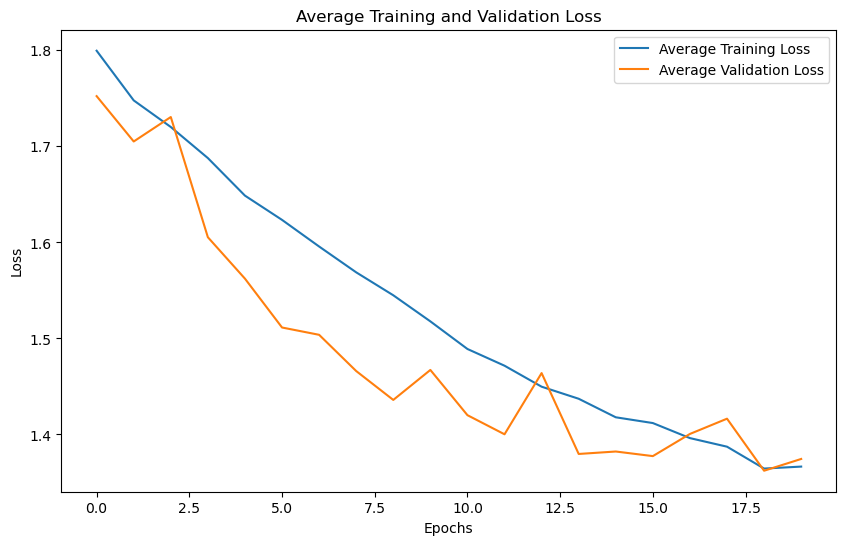

In [10]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model2_1[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss2_1 = []
avg_val_loss2_1 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model2_1]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model2_1]
    
    avg_loss2_1.append(np.mean(epoch_loss))
    avg_val_loss2_1.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss2_1, label='Average Training Loss')
plt.plot(avg_val_loss2_1, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

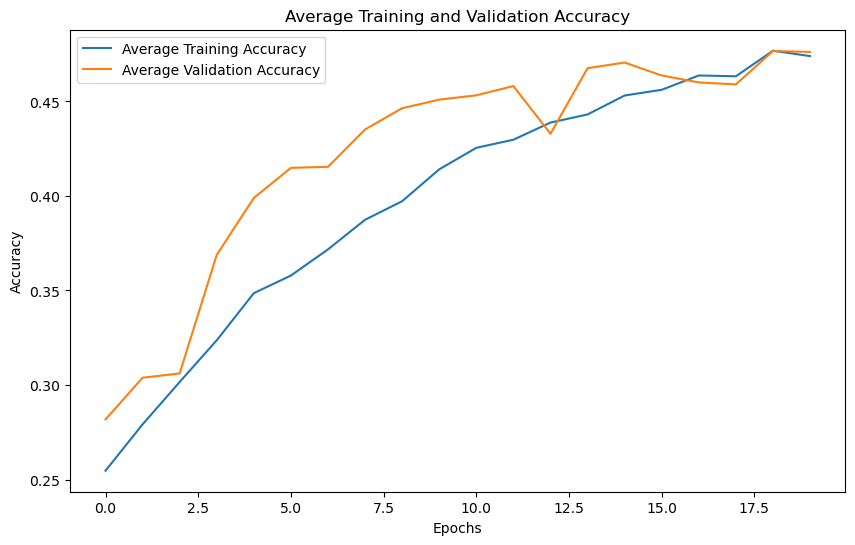

In [11]:
# Initialize lists to store the average accuracy and validation accuracy across all instances
avg_accuracy2_1 = []
avg_val_accuracy2_1 = []

# Calculate the average accuracy and validation accuracy for each epoch
for epoch in range(num_epochs):
    epoch_accuracy = [result['accuracy'][epoch] for result in training_results_model2_1]
    epoch_val_accuracy = [result['val_accuracy'][epoch] for result in training_results_model2_1]
    
    avg_accuracy2_1.append(np.mean(epoch_accuracy))
    avg_val_accuracy2_1.append(np.mean(epoch_val_accuracy))

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_accuracy2_1, label='Average Training Accuracy')
plt.plot(avg_val_accuracy2_1, label='Average Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# !!! F1 SCORE INSTEAD OF ACCURACY


# Initialize lists to store the average F1 score and validation F1 score across all instances
avg_f1_score2_1 = []
avg_val_f1_score2_1 = []

# Calculate the average F1 score and validation F1 score for each epoch
for epoch in range(num_epochs):
    epoch_f1_score = [result['f1_score'][epoch] for result in training_results_model2_1]
    epoch_val_f1_score = [result['val_f1_score'] [epoch] for result in training_results_model2_1]
    
    avg_f1_score2_1.append(np.mean(epoch_f1_score))
    avg_val_f1_score2_1.append(np.mean(epoch_val_f1_score))

# Plot the average F1 score for training and validation across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_f1_score2_1, label='Average Training F1 Score')
plt.plot(avg_val_f1_score2_1, label='Average Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Average Training and Validation F1 Score')
plt.legend()
plt.show()



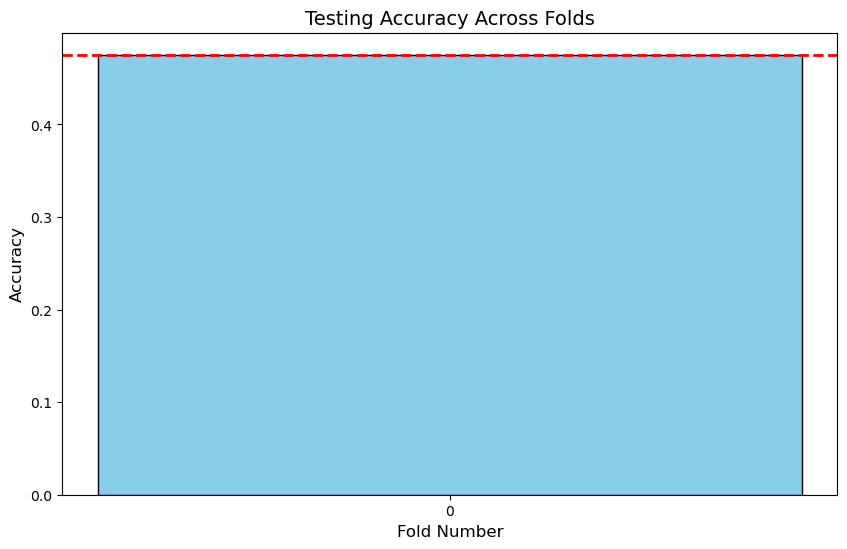

Average Accuracy:  0.47526973485946655
Standard Deviation:  0.0


In [25]:
# Calculate the average tseting accuracy
average2_1 = np.mean(testing_results_model2_1)
std2_1 = np.std(testing_results_model2_1)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model2_1)), testing_results_model2_1, color='skyblue', edgecolor='black', label='Values')

# Plot the average as a horizontal line
plt.axhline(average2_1, color='red', linestyle='--', linewidth=2, label=f'Average ({average2_1:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Testing Accuracy Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model2_1)))

# Show the plot
plt.show()

# Print average and standard deviation for accuracy
print("Average Accuracy: ", average2_1)
print("Standard Deviation: " , std2_1)

In [ ]:
# !!! it's the above code but for f1

# Calculate the average testing F1 score and standard deviation
average_f1_score2_1 = np.mean(testing_results_model2_1)
std_f1_score2_1 = np.std(testing_results_model2_1)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model2_1)), testing_results_model2_1, color='skyblue', edgecolor='black', label='F1 Scores')

# Plot the average as a horizontal line
plt.axhline(average_f1_score2_1, color='red', linestyle='--', linewidth=2, label=f'Average F1 Score ({average_f1_score2_1:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Testing F1 Score Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model2_1)))

# Show the plot
plt.legend()
plt.show()

# Print average and standard deviation for F1 score
print("Average F1 Score: ", average_f1_score2_1)
print("Standard Deviation: ", std_f1_score2_1)

#### Model 2 with Changed Parameters

In [19]:
# for tracking performance
training_results_model2_2 = []
testing_results_model2_2 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    ### REPLACE THIS    
    # changes: 
    #    1. Baseline: 2 conv layers and two output layers
    cnn1 = Sequential()

    # data augmentation 
    cnn1.add(RandomFlip("horizontal"))
    cnn1.add(RandomRotation(0.10))
    cnn1.add(RandomTranslation(height_factor=0.1, width_factor=0.1))
    cnn1.add(RandomZoom(height_factor=0.1, width_factor=0.1))

    num_filt_layers = [36, 36]
    for num_filters in num_filt_layers:
        cnn1.add( Conv2D(filters=num_filters, 
                        kernel_size=(5,5), 
                        padding='same') )
        cnn1.add( Activation('relu'))
        cnn1.add( MaxPooling2D(pool_size=(3, 3), 
                            ) )
        

    # add one layer on flattened output
    cnn1.add( Flatten() )
    cnn1.add( Dense(1024, activation='relu') )
    cnn1.add( Dense(512, activation='relu') )
    cnn1.add( Dense(128, activation='relu') )
    cnn1.add( Dense(7, activation='softmax') )

    # Let's train the model 
    cnn1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    input_shape = [None, 48,48,3]
    cnn1.build(input_shape)

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    history = cnn1.fit(X_train_split, y_train_split, 
            batch_size=64, epochs=20, 
            shuffle=True, verbose=1,
            validation_data=(X_val,y_val))

    # track accuracy and loss for training data and validation data
    training_results_model2_2.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })

    # evaluate the model on the test data
    test_loss, test_accuracy = cnn1.evaluate(X_test, y_test)
    # add verbose = 0 later!!

    # remove the print statements later
    # we won't want them when we run 10 times
    print('Test Loss: ', test_loss)
    print("Test Accuracy:", test_accuracy)

    testing_results_model2_2.append(test_accuracy)

    # breaking for now so that we don't waste time running it a billion times (actually only five times LOLLLLL)
    break

Epoch 1/20
357/357 [==============================] - 47s 128ms/step - loss: 1.8050 - accuracy: 0.2493 - val_loss: 1.7585 - val_accuracy: 0.2816
Epoch 2/20
357/357 [==============================] - 50s 139ms/step - loss: 1.7370 - accuracy: 0.2837 - val_loss: 1.6839 - val_accuracy: 0.3159
Epoch 3/20
357/357 [==============================] - 48s 135ms/step - loss: 1.7022 - accuracy: 0.3063 - val_loss: 1.6309 - val_accuracy: 0.3511
Epoch 4/20
357/357 [==============================] - 48s 135ms/step - loss: 1.6570 - accuracy: 0.3390 - val_loss: 1.5515 - val_accuracy: 0.3884
Epoch 5/20
357/357 [==============================] - 51s 144ms/step - loss: 1.6186 - accuracy: 0.3596 - val_loss: 1.5318 - val_accuracy: 0.4007
Epoch 6/20
357/357 [==============================] - 56s 157ms/step - loss: 1.5885 - accuracy: 0.3784 - val_loss: 1.5173 - val_accuracy: 0.4058
Epoch 7/20
357/357 [==============================] - 59s 165ms/step - loss: 1.5587 - accuracy: 0.3944 - val_loss: 1.4971 - val_ac

In [ ]:
# !!! f1 score


# Track accuracy and loss for training data and validation data
    training_results_model2_2.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })

    # Evaluate the model on the test data
    y_test_pred = cnn1.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate F1 score for the test data (weighted average)
    test_f4 = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')
    print("Test F1 Score:", test_f4)

    # Track the F1 score for each fold
    testing_results_model2_2.append(test_f4)

    # Breaking for now to avoid running too many times (only for debugging)
    break







# Optionally, calculate the average F1 score and standard deviation across all folds
average_f1_score2_1 = np.mean(testing_results_model2_1)
std_f1_score2_1 = np.std(testing_results_model2_1)

# Print the average F1 score and standard deviation
print("Average F1 Score: ", average_f1_score2_1)
print("Standard Deviation of F1 Scores: ", std_f1_score2_1)

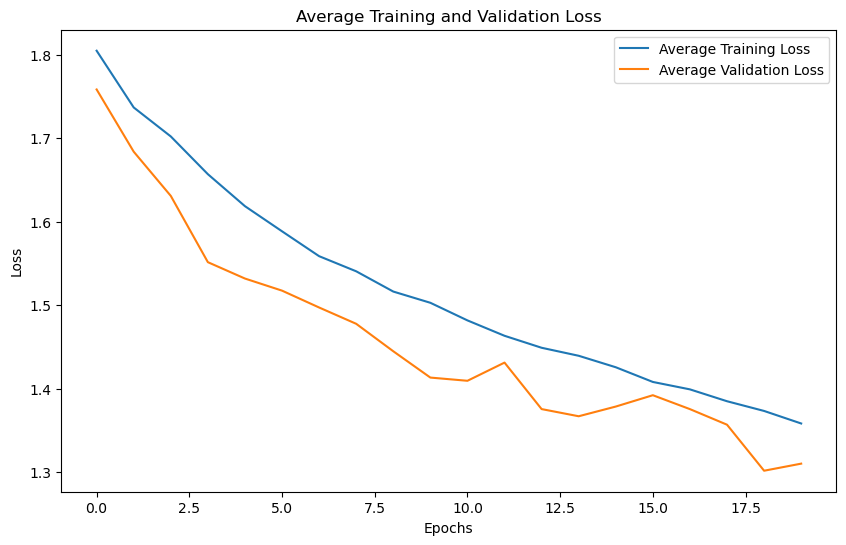

In [20]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model2_2[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss2_2 = []
avg_val_loss2_2 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model2_2]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model2_2]
    
    avg_loss2_2.append(np.mean(epoch_loss))
    avg_val_loss2_2.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss2_2, label='Average Training Loss')
plt.plot(avg_val_loss2_2, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

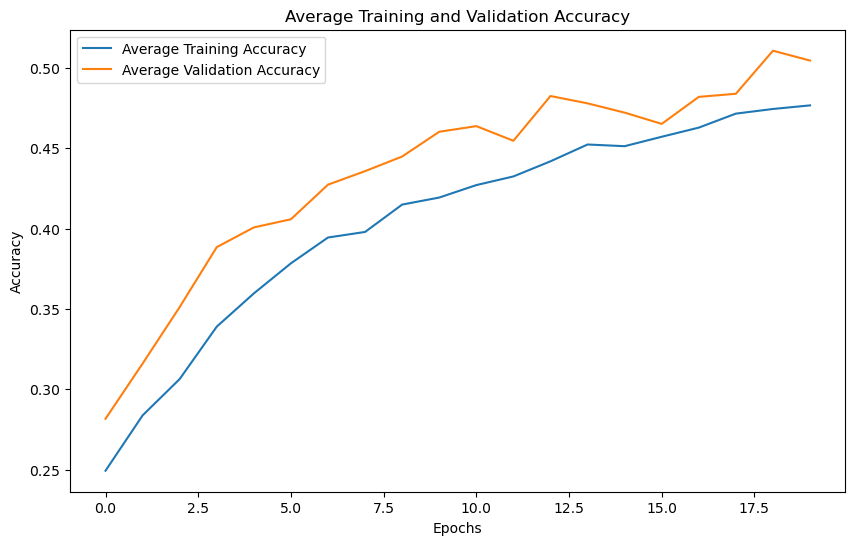

In [21]:
# Initialize lists to store the average accuracy and validation accuracy across all instances
avg_accuracy2_2 = []
avg_val_accuracy2_2 = []

# Calculate the average accuracy and validation accuracy for each epoch
for epoch in range(num_epochs):
    epoch_accuracy = [result['accuracy'][epoch] for result in training_results_model2_2]
    epoch_val_accuracy = [result['val_accuracy'][epoch] for result in training_results_model2_2]
    
    avg_accuracy2_2.append(np.mean(epoch_accuracy))
    avg_val_accuracy2_2.append(np.mean(epoch_val_accuracy))

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_accuracy2_2, label='Average Training Accuracy')
plt.plot(avg_val_accuracy2_2, label='Average Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# !!! it's the above code but for f1

# Calculate the average testing F1 score and standard deviation
average_f1_score2_2 = np.mean(testing_results_model2_2)
std_f1_score2_2 = np.std(testing_results_model2_2)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model2_2)), testing_results_model2_2, color='skyblue', edgecolor='black', label='F1 Scores')

# Plot the average as a horizontal line
plt.axhline(average_f1_score2_2, color='red', linestyle='--', linewidth=2, label=f'Average F1 Score ({average_f1_score2_2:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Testing F1 Score Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model2_2)))

# Show the plot
plt.legend()
plt.show()

# Print average and standard deviation for F1 score
print("Average F1 Score: ", average_f1_score2_2)
print("Standard Deviation: ", std_f1_score2_2)

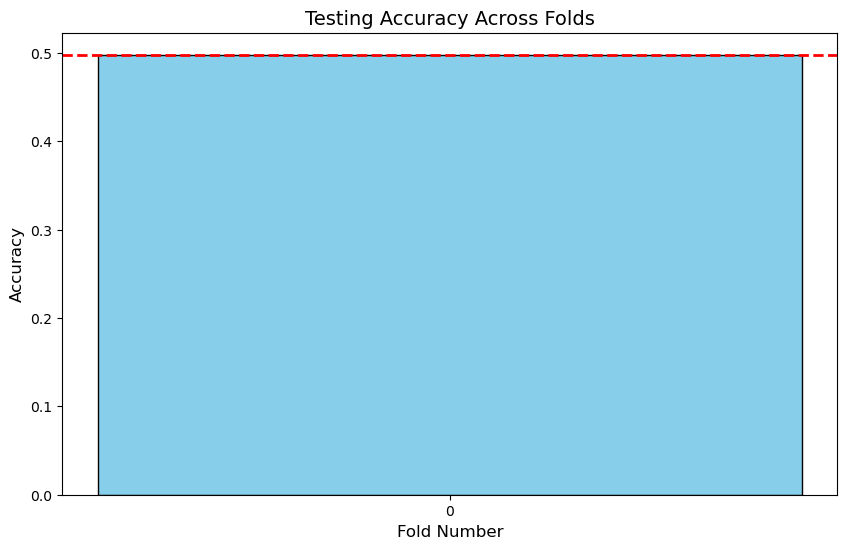

Average Accuracy:  0.4978282153606415
Standard Deviation:  0.0


In [26]:
# Calculate the average tseting accuracy
average2_2 = np.mean(testing_results_model2_2)
std2_2 = np.std(testing_results_model2_2)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model2_2)), testing_results_model2_2, color='skyblue', edgecolor='black', label='Values')

# Plot the average as a horizontal line
plt.axhline(average2_2, color='red', linestyle='--', linewidth=2, label=f'Average ({average2_2:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Testing Accuracy Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model2_2)))

# Show the plot
plt.show()

# Print average and standard deviation for accuracy
print("Average Accuracy: ", average2_2)
print("Standard Deviation: " , std2_2)

In [ ]:
# !!! it's the above code but for f1

# Calculate the average testing F1 score and standard deviation
average_f1_score2_2 = np.mean(testing_results_model2_2)
std_f1_score2_2 = np.std(testing_results_model2_2)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model2_2)), testing_results_model2_2, color='skyblue', edgecolor='black', label='F1 Scores')

# Plot the average as a horizontal line
plt.axhline(average_f1_score2_2, color='red', linestyle='--', linewidth=2, label=f'Average F1 Score ({average_f1_score2_2:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Testing F1 Score Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model2_2)))

# Show the plot
plt.legend()
plt.show()

# Print average and standard deviation for F1 score
print("Average F1 Score: ", average_f1_score2_2)
print("Standard Deviation: ", std_f1_score2_2)

### Performance Comparison

### MLP Code

In [12]:
# values we need for the plot (we will plot only one of the ten instances of the model)
ex_fpr1 = dict()
ex_tpr1 = dict()
ex_roc_auc1 = dict()
count = 0

# for tracking performance of all 10 splits
micro_aucs1 = []
macro_aucs1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # track the number split we're on, so we can save the data for the first split
    count += 1
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    ### REPLACE THIS    
    # make a keras MLP
    mlp = Sequential()
    mlp.add( Flatten() )
    mlp.add( Dense(input_dim=1, units=1024, activation='relu') )
    mlp.add( Dense(units=512, activation='relu') )
    mlp.add( Dense(units=128, activation='relu') )
    mlp.add( Dense(7) ) #not sure about this
    mlp.add( Activation('softmax') )

    mlp.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    input_shape = [None, 48,48,3]
    mlp.build(input_shape)

    history = mlp.fit(X_train_split, y_train_split, 
            batch_size=64, epochs=8, 
            shuffle=True, verbose=1)

    # Predict probabilities on the test set (needed for ROC curve)
    y_pred_proba = mlp.predict(X_test, verbose=0)  # This gives predicted probabilities for each class
    y_pred_labels = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels

    # find the true labels
    y_true = np.argmax(y_test, axis=1)

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = 7  # Number of classes

    for i in range(n_classes):
        # For each class, calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute Macro and Micro AUCs
    macro_auc = roc_auc_score(y_true, y_pred_proba, average="macro", multi_class="ovr")
    micro_auc = roc_auc_score(y_true, y_pred_proba, average="micro", multi_class="ovr")

    # add to list to store
    macro_aucs1.append(macro_auc)
    micro_aucs1.append(micro_auc)

    #save the data for the first split
    if count == 1:
        ex_fpr1 = fpr
        ex_tpr1 = tpr
        ex_roc_auc1 = roc_auc

    # breaking for now so that we don't waste time running it a billion times (actually only five times LOLLLLL)
    break

Epoch 1/8
357/357 [==============================] - 17s 45ms/step - loss: 1.9306 - accuracy: 0.2585
Epoch 2/8
357/357 [==============================] - 17s 46ms/step - loss: 1.7205 - accuracy: 0.3176
Epoch 3/8
357/357 [==============================] - 16s 46ms/step - loss: 1.6956 - accuracy: 0.3306
Epoch 4/8
357/357 [==============================] - 16s 46ms/step - loss: 1.6595 - accuracy: 0.3473
Epoch 5/8
357/357 [==============================] - 16s 45ms/step - loss: 1.6418 - accuracy: 0.3530
Epoch 6/8
357/357 [==============================] - 17s 47ms/step - loss: 1.6231 - accuracy: 0.3661
Epoch 7/8
357/357 [==============================] - 17s 48ms/step - loss: 1.6077 - accuracy: 0.3732
Epoch 8/8
357/357 [==============================] - 17s 48ms/step - loss: 1.5968 - accuracy: 0.3776


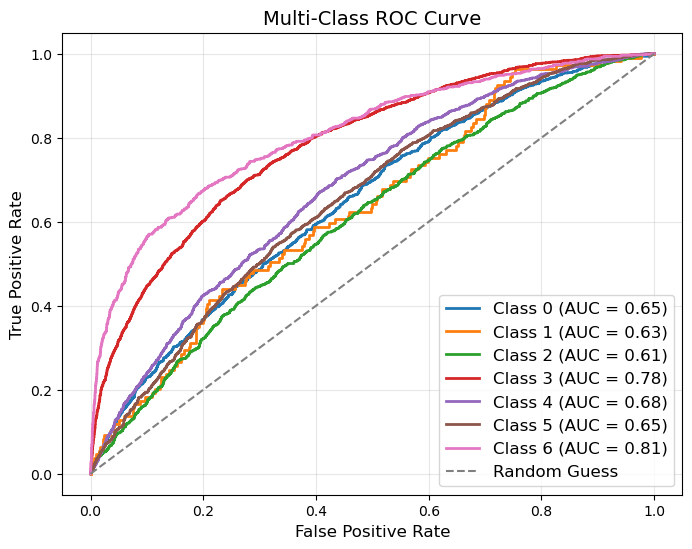

In [13]:
# Plot ROC curve for each class
n_classes = 7

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(ex_fpr1[i], ex_tpr1[i], lw=2, label=f"Class {i} (AUC = {ex_roc_auc1[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multi-Class ROC Curve", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()